In [1]:
import pandas as pd
from drn_interactions.config import Config
from drn_interactions.interactions.popcup import PopulationCoupling
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.loaders import SpontaneousActivityLoader
from drn_interactions.interactions.pairwise import PairwiseCorr, PairwisePartialCorr
from drn_interactions.interactions.runners import InteractionsRunner
from drn_interactions.io import load_derived_generic
from drn_interactions.config import Config

dd = Config.derived_data_dir / "corrs"
dd.mkdir(exist_ok=True)

## Get Pairwise Interactions

In [ ]:
neuron_types = load_derived_generic("neuron_types.csv")
sessions = neuron_types["session_name"].dropna().unique()

res_corr = []
res_pcorr = []
res_pcup = []
bin_widths = [0.05, 0.1, 0.5, 1, 2, 5]

loader_fac = lambda bin_width: SpontaneousActivityLoader(
    session_name=sessions[0], bin_width=bin_width
)
preprocessor_fac = lambda: InteractionsPreprocessor(
    z=True, minmax=False, gaussian_sigma=None
)
corr_fac = lambda: PairwiseCorr()
pcorr_fac = lambda: PairwisePartialCorr()
pcup_fac = lambda: PopulationCoupling()

runner_fac = lambda bin_width: InteractionsRunner(
    loader=loader_fac(bin_width),
    preprocessor=preprocessor_fac(),
    pcup=pcup_fac(),
    corr=corr_fac(),
    pcorr=pcorr_fac(),
)
for bin_width in bin_widths:
    runner = runner_fac(bin_width)
    res_pcorr.append(runner.run_pcorr_multi(sessions).assign(bin_width=bin_width))
    res_corr.append(runner.run_corr_multi(sessions).assign(bin_width=bin_width))
    res_pcup.append(runner.run_pcup_multi(sessions).assign(bin_width=bin_width))

res_corr = pd.concat(res_corr).reset_index(drop=True)
res_pcorr = pd.concat(res_pcorr).reset_index(drop=True)
res_pcup = pd.concat(res_pcup).reset_index(drop=True)

res_pcorr.to_csv(dd / "spont - pcorr.csv", index=False)
res_corr.to_csv(dd / "spont - corr.csv", index=False)
res_pcup.to_csv(dd / "spont - pcup.csv", index=False)

In [ ]:
runner = runner_fac(1)
pcorr_reps = runner.pcorr_bootstrap_multi(sessions=sessions, n_boot=100)
corr_reps = runner.corr_bootstrap_multi(sessions=sessions, n_boot=100)
pcup_reps = runner.pcup_bootstrap_multi(sessions=sessions, n_boot=100)

pcorr_reps.to_parquet(
    dd / "spont - pcorr_reps.parquet.gzip", index=False, compression="gzip"
)
corr_reps.to_parquet(
    dd / "spont - corr_reps.parquet.gzip", index=False, compression="gzip"
)
pcup_reps.to_parquet(
    dd / "spont - pcup_reps.parquet.gzip", index=False, compression="gzip"
)


In [137]:
import numpy as np
from drn_interactions.stats import p_adjust

def get_p(row: pd.Series, reps: pd.DataFrame, value_col: str, comb_col: str = "comb"):
    obs = row[value_col]
    comb = row[comb_col]
    rep_vals = reps.query(f"{comb_col} == @comb")[value_col].values
    p = np.mean(np.abs(rep_vals) > np.abs(obs))
    return p


pcorr_reps = pd.read_parquet(dd / "spont - pcorr_reps.parquet.gzip")
corr_reps = pd.read_parquet(dd / "spont - corr_reps.parquet.gzip")
pcup_reps = pd.read_parquet(dd / "spont - pcup_reps.parquet.gzip")

pcorr_obs = load_derived_generic("corrs/spont - pcorr.csv").query("bin_width == 1")
corr_obs = load_derived_generic("corrs/spont - corr.csv").query("bin_width == 1")
pcup_obs = load_derived_generic("corrs/spont - pcup.csv").query("bin_width == 1")


pcorr_obs["p"] = p_adjust(pcorr_obs.apply(get_p, reps=pcorr_reps, value_col="pcorr", axis=1))
corr_obs["p"] = p_adjust(corr_obs.apply(get_p, reps=corr_reps, value_col="corr", axis=1))
pcup_obs["p"] = p_adjust(pcup_obs.apply(get_p, reps=pcup_reps, value_col="cc", comb_col="neuron_id", axis=1))


pcorr_obs["sig"] = pcorr_obs["p"] < 0.05
corr_obs["sig"] = corr_obs["p"] < 0.05
pcup_obs["sig"] = pcup_obs["p"] < 0.05

pcorr_obs.to_csv(dd / "spont - pcorr - 1s.csv", index=False)
corr_obs.to_csv(dd / "spont - corr - 1s.csv", index=False)
pcup_obs.to_csv(dd / "spont - pcup - 1s.csv", index=False)

/opt/miniconda3/envs/drn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/drn/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [138]:
from drn_interactions.transforms.graph import GraphTransformer


neuron_types = load_derived_generic("neuron_types.csv")

corr_obs_nt = GraphTransformer()._add_neuron_type_comb_col(
    df_edge=corr_obs,
    df_neuron_types=neuron_types,
    source_col="neuron_1",
    target_col="neuron_2",
)

pcorr_obs_nt = GraphTransformer()._add_neuron_type_comb_col(
    df_edge=pcorr_obs,
    df_neuron_types=neuron_types,
    source_col="neuron_1",
    target_col="neuron_2",
)

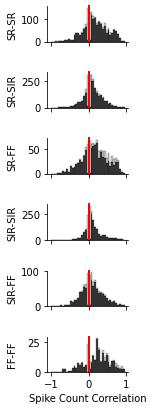

In [139]:
from drn_interactions.plots import PAL_GREY_BLACK
import seaborn as sns

row_order = (
    "SR-SR",
    "SR-SIR",
    "SR-FF",
    "SIR-SIR",
    "SIR-FF",
    "FF-FF"
)
g = sns.FacetGrid(
    row="nt_comb", 
    data=corr_obs_nt, 
    aspect=2, 
    height=1, 
    sharey=False,
    row_order=row_order,
    )

g.map_dataframe(
    sns.histplot, 
    x="corr", 
    hue="sig", 
    bins=np.arange(-1, 1, 0.05),
    palette=PAL_GREY_BLACK[::-1],
    multiple="stack",
    )


g.refline(x=0, linewidth=2, linestyle="-", color="red", clip_on=False)

g.set_titles("")
g.set_xlabels("Spike Count Correlation")

for lab, ax in g.axes_dict.items():
    ax.set_ylabel(lab)

g.figure.align_ylabels()

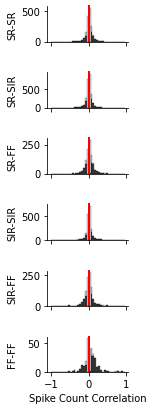

In [140]:
g = sns.FacetGrid(
    row="nt_comb", 
    data=pcorr_obs_nt, 
    aspect=2, 
    height=1, 
    sharey=False,
    row_order=row_order,
    )

g.map_dataframe(
    sns.histplot, 
    x="pcorr", 
    hue="sig", 
    bins=np.arange(-1, 1, 0.05),
    palette=PAL_GREY_BLACK[::-1],
    multiple="stack",
    )


g.refline(x=0, linewidth=2, linestyle="-", color="red", clip_on=False)

g.set_titles("")
g.set_xlabels("Spike Count Correlation")

for lab, ax in g.axes_dict.items():
    ax.set_ylabel(lab)

g.figure.align_ylabels()

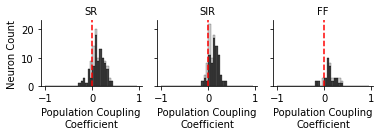

In [141]:
pcup_nt = pcup_obs.dropna().merge(neuron_types, on="neuron_id")

g = sns.FacetGrid(
    col="neuron_type", 
    data=pcup_nt, 
    aspect=0.9, 
    height=2, 
    sharey=True,
    row_order=("SR", "SIR", "FF"),
    )

g.map_dataframe(
    sns.histplot, 
    x="cc", 
    hue="sig", 
    bins=np.arange(-1, 1, 0.05),
    palette=PAL_GREY_BLACK[::-1],
    multiple="stack",
    )


g.set_xlabels("Population Coupling\nCoefficient")
g.figure.align_xlabels()
g.refline(x=0, color="red")
g.set_titles("{col_name}")
g.set_ylabels("Neuron Count")

### Numbers

In [155]:
# corr pcorr and pcup mag neuron type (and comb)
# corr pcorr and pcup sig by neuron type
import ezbootstrap as ez
from drn_interactions.stats import se_mean

nums_corr = (
    corr_obs_nt
    .assign(mag=lambda x: np.abs(x["corr"]))
    .groupby(["nt_comb"])
    ["corr"]
    .apply(lambda x: (x.mean().round(3), se_mean(x.values).round(3) ) )
)

nums_pcorr = (
    pcorr_obs_nt
    .assign(mag=lambda x: np.abs(x["pcorr"]))
    .groupby(["nt_comb"])
    ["pcorr"]
    .apply(lambda x: (x.mean().round(3), se_mean(x.values).round(3) ) )
)

nums_pcup = (
    pcup_nt
    .assign(mag=lambda x: np.abs(x["cc"]))
    .groupby(["neuron_type"])
    ["cc"]
    .apply(lambda x: (x.mean().round(3), se_mean(x.values).round(3) ) )
)

In [162]:
nums_pcorr.to_frame().join(nums_corr).iloc[::-1, ::-1]

,corr,pcorr
nt_comb,,
SR-SR,"(0.177, 0.007)","(0.015, 0.002)"
SR-SIR,"(0.102, 0.005)","(0.008, 0.002)"
SR-FF,"(0.178, 0.01)","(0.018, 0.003)"
SIR-SIR,"(0.101, 0.005)","(0.015, 0.002)"
SIR-FF,"(0.093, 0.009)","(0.011, 0.004)"
FF-FF,"(0.238, 0.02)","(0.048, 0.01)"


In [158]:
display(nums_pcup)

neuron_type
FF       (0.12, 0.02)
SIR    (0.104, 0.011)
SR     (0.114, 0.014)
Name: cc, dtype: object